# 3.1 Data Preparation

In [177]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from collections import OrderedDict

#third party imports
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import rcParams
import seaborn as sns

#local imports
import analysis.dataPreparer as dp

In [230]:
#setup
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (10, 6)

save_path = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original/figures/design/"

In [299]:
def auto_label(ax, fmt='{:,.0f}'):
    ymax_old = ax.get_ylim()[1]
    ax.set_ylim(ymax= ax.get_ylim()[1] * 1.1)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+p.get_width()/2.,
            y=np.nanmax([height,0]) + ymax_old * 0.02,
            s=fmt.format(np.nanmax([height,0])),
            ha="center")
    ax.yaxis.set_ticks([])

In [552]:
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

In [380]:
def add_vertical_line(ax, value, label, color, linestyle="dashed"):
    ax.axvline(value, linestyle=linestyle, color=color)
    x_bounds = ax.get_xlim()
    xy_pos = (((value-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01)
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [5]:
#constants
input_path = path+"analysis/input/master.db"
flatten_config = path+"analysis/config/master_feature.sql"
raw_flat_file = path+"analysis/output/temp/raw.csv"
clean_flat_file = path+"analysis/output/temp/clean.csv"
output_path = path+"analysis/output/temp/output.db"
#output_path = path+"analysis/output/autoVC/8/test/2015-04-06/2017-04-03/label_clean.csv"

#dp.flatten_file(input_path, flatten_config, raw_flat_file, "feature")
#dp.clean_file(raw_flat_file, clean_flat_file)
#dp.load_file(output_path, clean_flat_file, "feature")
df = dp.export_dataframe(output_path, "feature")
df_backup = df.copy()

logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 105.93


In [91]:
#reload data from memory
df = df_backup

In [ ]:
df = df.sample(50000)

In [92]:
stage_features = dict(
    Age = 'confidence_context_broader_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool"
)

In [93]:
def create_stages(df, **features):
    df2 = df.copy()
    df2["keys_company_stage"] = "Other"
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Closed"]] >= 1), "Closed", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Acquired"]] >= 1), "Acquired", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["IPO"]] >= 1), "IPO", df2["keys_company_stage"])
    df2["keys_company_stage_series-d+"] = df2[[features["SeriesD"],features["SeriesE"],features["SeriesF"],features["SeriesG"],features["SeriesH"]]].sum(axis=1)
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2["keys_company_stage_series-d+"] >= 1), "Series D+", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesC"]] >= 1), "Series C", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesB"]] >= 1), "Series B", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesA"]] >= 1), "Series A", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["FundingRaised"]] >= 0), "Seed", df2["keys_company_stage"])
    age_new_cutoff = df2[features["Age"]][df2["keys_company_stage"] == "Seed"].quantile(0.75)
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Age"]] <= age_new_cutoff), "Pre-Seed", df2["keys_company_stage"])
    group_stages = {"Other" : "Excluded", "Closed" : "Excluded", "IPO" : "Excluded", "Acquired" : "Excluded", "Pre-Seed" : "Included",
        "Seed" : "Included", "Series A" : "Included", "Series B" : "Included", "Series C" : "Included", "Series D+" : "Included"}
    df2["keys_company_stage_group"] = df2["keys_company_stage"].map(group_stages)
    ordinal_stages = {"Pre-Seed" : 1, "Seed" : 2, "Series A" : 3, "Series B" : 4, "Series C" : 5, "Series D+" : 6,"Other" : np.nan, "Closed" : -1, "IPO" : 7, "Acquired" : 8}
    df2["keys_company_stage_number"] = df2["keys_company_stage"].map(ordinal_stages)
    return df2[["keys_company_stage_group", "keys_company_stage","keys_company_stage_number"]]

In [94]:
stages = create_stages(df, **stage_features)
df = pd.concat([stages, df], axis=1)
print("Stages done.")

Stages done.


## 3.1.3 Preliminary Screening

In [95]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Other        206872
Pre-Seed     113915
Seed          52219
Acquired      26894
Series A       8654
IPO            5800
Series B       4657
Closed         3279
Series C       2231
Series D+      1413
Name: keys_company_stage, dtype: int64
Other        0.485690
Pre-Seed     0.267448
Seed         0.122599
Acquired     0.063141
Series A     0.020318
IPO          0.013617
Series B     0.010934
Closed       0.007698
Series C     0.005238
Series D+    0.003317
Name: keys_company_stage, dtype: float64
425934


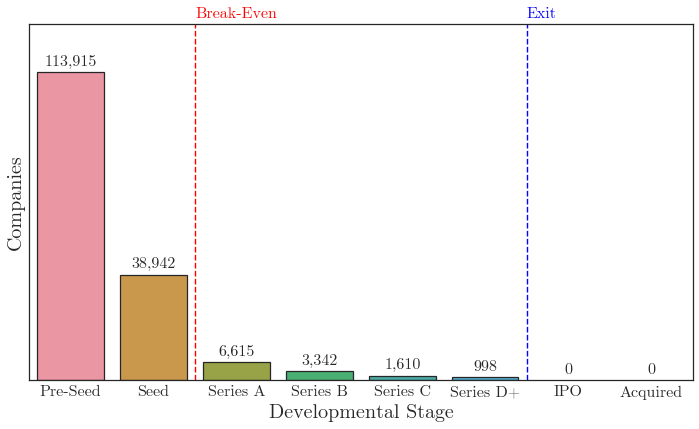

In [245]:
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+", "IPO", "Acquired"]
f = plt.figure()
ax = sns.countplot(x= df["keys_company_stage"], order = order_1, **outline_bars)
auto_label(ax)
add_vertical_line(ax, 1.5, "Break-Even", color="r")
add_vertical_line(ax, 5.5, "Exit", color="b")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("Companies")
plt.tight_layout()
#f.savefig(save_path+"lifecycle.pdf", bbox_inches="tight")

Removed Other, Closed, Acquired & IPO groups

In [97]:
df = df.loc[df['keys_company_stage_group'] != "Excluded"]

In [98]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Pre-Seed     113915
Seed          52219
Series A       8654
Series B       4657
Series C       2231
Series D+      1413
Name: keys_company_stage, dtype: int64
Pre-Seed     0.622184
Seed         0.285211
Series A     0.047267
Series B     0.025436
Series C     0.012185
Series D+    0.007718
Name: keys_company_stage, dtype: float64
183089


In [99]:
age_old_cutoff = df["confidence_context_broader_company_age_number"][df["keys_company_stage"] == "Series D+"].quantile(0.75)

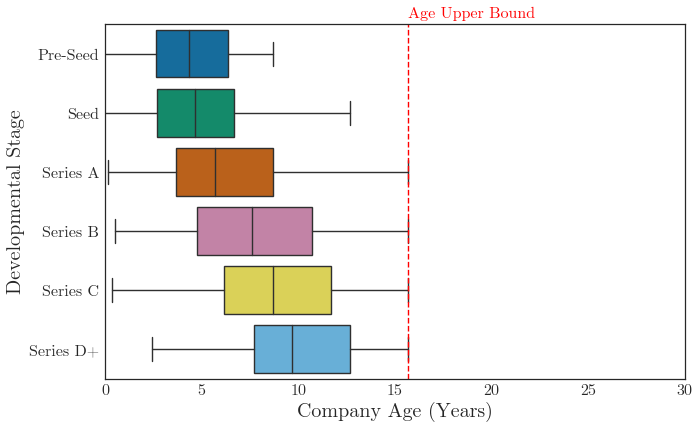

In [246]:
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]
f = plt.figure()
ax = sns.boxplot(
    x="confidence_context_broader_company_age_number", 
    y="keys_company_stage",
    order=order_1,data=df, fliersize=0)
ax.set_xlim(xmin=0, xmax=30)
ax.set_xlabel("Company Age (Years)")
ax.set_ylabel("Developmental Stage")
add_vertical_line(ax, age_old_cutoff, "Age Upper Bound", color="r")
plt.tight_layout()
#f.savefig(save_path+"stages_ages.pdf", bbox_inches="tight")

Removed companies older than 15 years old

In [101]:
age_old_cutoff

15.698630136986301

In [102]:
df = df.loc[df['confidence_context_broader_company_age_number'] <= age_old_cutoff]

In [103]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Pre-Seed     113915
Seed          38942
Series A       6615
Series B       3342
Series C       1610
Series D+       998
Name: keys_company_stage, dtype: int64
Pre-Seed     0.688633
Seed         0.235410
Series A     0.039989
Series B     0.020203
Series C     0.009733
Series D+    0.006033
Name: keys_company_stage, dtype: float64
165422


## 3.1.4 Descriptive Statistics

Table 3. Final test dataset counts grouped by lifecycle stage.

In [104]:
drops = [col for col in list(df) if col.startswith(("key","from","outcome","index"))]
X = df.drop(drops, axis=1)
X = X.select_dtypes(['number'])

In [105]:
df["keys_missing_features"] = X.isnull().sum(axis=1)
len(list(df))

419

In [106]:
groups = [df["keys_company_stage"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Obs Age (Years)            \
                         N      Median       IQR   
keys_company_stage                                 
Pre-Seed            113915    4.361644  3.736986   
Seed                 38942    4.663014  4.002740   
Series A              6615    5.693151  5.005479   
Series B              3342    7.608219  5.917808   
Series C              1610    8.695890  5.523288   
Series D+              998    9.695890  5.005479   

                   Funding Raised (USD, millions)             \
                                           Median        IQR   
keys_company_stage                                             
Pre-Seed                                      NaN        NaN   
Seed                                     0.250000   1.295000   
Series A                                 4.400000   7.905574   
Series B                                14.891075  22.032250   
Series C                                35.285000  45.880783   
Series D+                               74.384997  90.299903   

                   Funding Rounds (N)      Available Features (N)       
                               Median  IQR                 Median  IQR  
keys_company_stage                                                      
Pre-Seed                          NaN  NaN                     33  127  
Seed                              1.0  1.0                    185  127  
Series A                          2.0  2.0                    246  117  
Series B                          3.0  2.0                    261   87  
Series C                          3.0  2.0                    311   80  
Series D+                         5.0  3.0                    324   69

In [107]:
groups = [df["keys_company_stage_group"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median), ("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]),
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Obs Age (Years)           \
                               N      Median      IQR   
keys_company_stage_group                                
Included                  165422    4.687671  4.00274   

                         Funding Raised (USD, millions)        \
                                                 Median   IQR   
keys_company_stage_group                                        
Included                                            NaN  3.97   

                         Funding Rounds (N)      Available Features (N)       
                                     Median  IQR                 Median  IQR  
keys_company_stage_group                                                      
Included                                1.0  1.0                     98  145

Table 3. Final test dataset counts grouped by company sector.

In [108]:
industries = [x for x in list(df) if x.startswith("confidence_context_industry_category_group_list")]

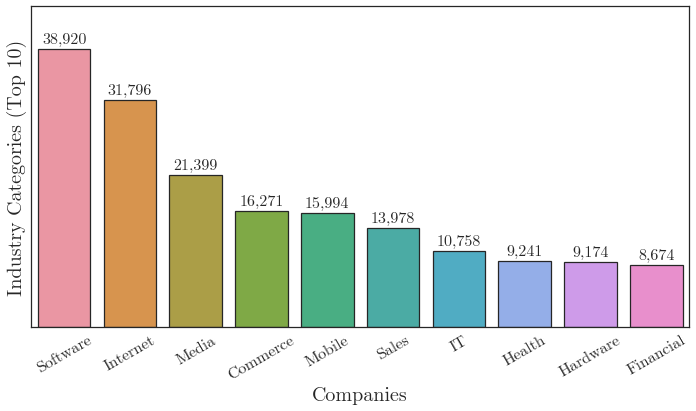

In [247]:
values = [df[industry].value_counts()[1] for industry in industries]
values = sorted(values,reverse=True)
f = plt.figure()
names = ["Software", "Internet", "Media", "Commerce", "Mobile", "Sales", "IT", "Health", "Hardware", "Financial"]
ax = sns.barplot(y = values, x = names, order = names,  **outline_bars)
auto_label(ax)
plt.xticks(rotation=30)
ax.set_xlabel("Companies")
ax.set_ylabel("Industry Categories (Top 10)")
plt.tight_layout()
#f.savefig(save_path+"industry_counts.pdf", bbox_inches="tight")

[SPARSITY]

In [362]:
missing_by_feature = X.isnull().sum(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


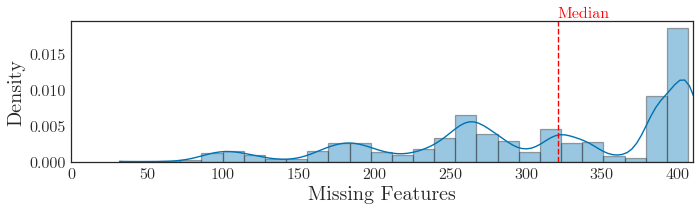

In [439]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(missing_by_feature, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=len(missing_by_col))
add_vertical_line(ax, np.median(missing_by_feature), "Median", color="r")
ax.set_xlabel("Missing Features")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"sparsity_features.pdf", bbox_inches="tight")

In [363]:
missing_by_col =  X.isnull().sum(axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


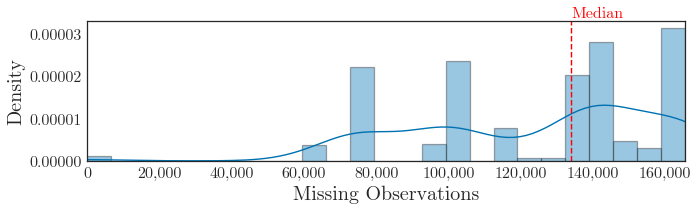

In [440]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(missing_by_col, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=len(missing_by_feature))
add_vertical_line(ax, np.median(missing_by_col), "Median", color="r")
ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Missing Observations")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"sparsity_observations.pdf", bbox_inches="tight")

[SKEW BY FEATURE (GROUPED BY WHETHER ZEROS-REMOVED)]

In [400]:
skews = X.apply(lambda x: stats.skew(x.dropna())).dropna()
skews = skews[(skews >= -20) & (skews < 40)]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


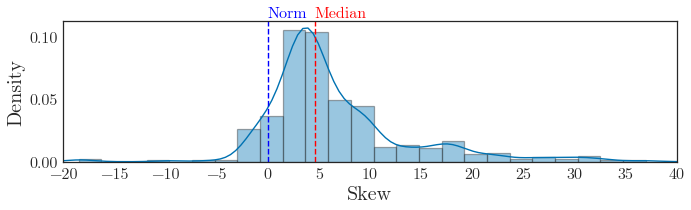

In [407]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(skews, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=-20, xmax=40)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
add_vertical_line(ax, 0, "Norm", color="b")
add_vertical_line(ax, np.median(skews), "Median", color="r")
ax.set_xlabel("Skew")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"skew.pdf", bbox_inches="tight")

In [402]:
kurtoses = X.apply(lambda x: stats.kurtosis(x.dropna())).dropna()
kurtoses = kurtoses[(kurtoses >= -25) & (kurtoses < 200)]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


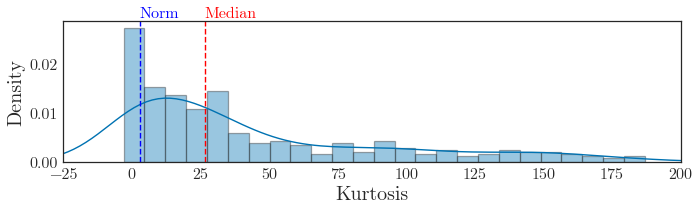

In [408]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(kurtoses, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=-25, xmax=200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
add_vertical_line(ax, 3, "Norm", color="b")
add_vertical_line(ax, np.median(kurtoses), "Median", color="r")
ax.set_xlabel("Kurtosis")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"kurtosis.pdf", bbox_inches="tight")

[KURTOSIS  BY FEATURE (GROUPED BY WHETHER ZEROS-REMOVED)]

[BOXPLOT OF FEATURES]

In [222]:
iqrs = X.apply(lambda x: stats.iqr(x.dropna())).dropna()
iqrs = np.log1p(iqrs)
iqrs = iqrs[(iqrs >= 0) & (iqrs < 25)]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


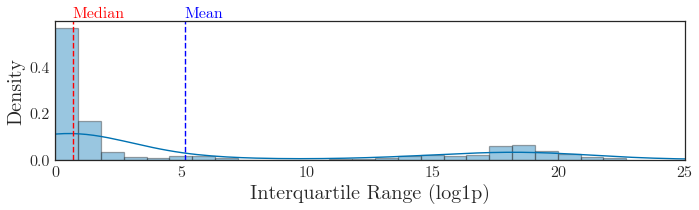

In [438]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(iqrs, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=25)
add_vertical_line(ax, np.mean(iqrs), "Mean", color="b")
add_vertical_line(ax, np.median(iqrs), "Median", color="r")
ax.set_xlabel("Interquartile Range (log1p)")
ax.set_ylabel("Density")
plt.tight_layout()
#f.savefig(save_path+"scaling.pdf", bbox_inches="tight")

[ORTHOGONALITY]

In [425]:
X_sample = X.sample(1000)
thresholds = [x*.1 for x in range(10)]

In [426]:
pearson = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="pearson").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
pearson = pd.DataFrame.from_dict(data=pearson, orient="index")
pearson["Method"] = "Pearson"

In [412]:
kendall = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="kendall").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
kendall = pd.DataFrame.from_dict(data=kendall, orient="index")
kendall["Method"] = "kendall"

In [427]:
spearman = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="spearman").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
spearman = pd.DataFrame.from_dict(data=spearman, orient="index")
spearman["Method"] = "Spearman"

In [428]:
corrs = pd.concat([spearman, pearson], axis=0)
corrs = corrs.drop(0.0)

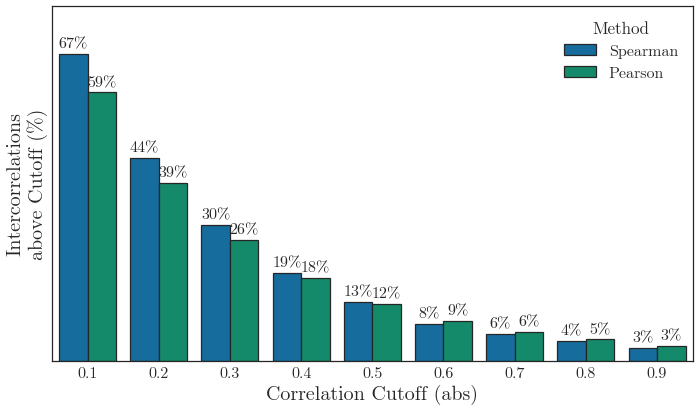

In [431]:
f = plt.figure()
ax = sns.barplot(x=corrs.index, y=corrs[0], hue=corrs["Method"], **outline_bars)
auto_label(ax, fmt='{:,.0f}%')
ax.set_xlabel("Correlation Cutoff (abs)")
ax.set_ylabel("Intercorrelations\nabove Cutoff (%)")
plt.tight_layout()
f.savefig(save_path+"orthogonality.pdf", bbox_inches="tight")

# 3.2 Pre-Processing

## 3.2.1 Imputation

Figure 3. Mean, median and mode of features (grouped bar plot).

In [526]:
means = X_sample.apply(lambda x: np.mean(x.dropna())).dropna()

In [527]:
medians = X_sample.apply(lambda x: np.median(x.dropna())).dropna()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [528]:
def get_mode(x):
    try: return stats.mode(x.dropna())[0][0]
    except: return np.nan

modes = X.apply(get_mode).dropna()

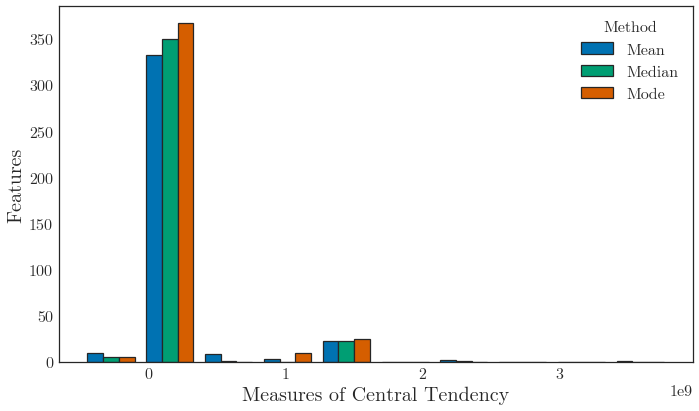

In [554]:
f = plt.figure()
plt.hist([means, medians, modes],label=["Mean","Median","Mode"], **outline_bars)
plt.xlabel("Measures of Central Tendency")
plt.ylabel("Features")
plt.legend(title="Method")
plt.tight_layout()
f.savefig(save_path+"central_tendency.pdf", bbox_inches="tight")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


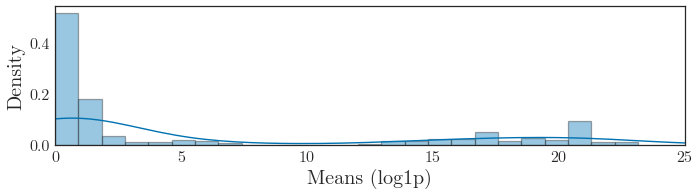

In [504]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(means, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=25)
ax.set_xlabel("Means (log1p)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"means.pdf", bbox_inches="tight")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


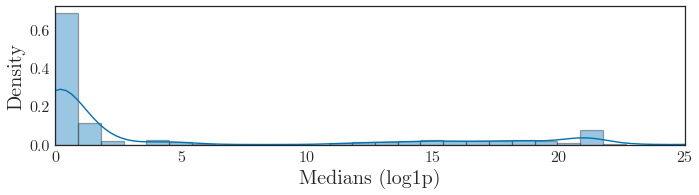

In [503]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(medians, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=25)
ax.set_xlabel("Medians (log1p)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"medians.pdf", bbox_inches="tight")

In [496]:
def get_mode(x):
    try: return stats.mode(x.dropna())[0][0]
    except: return np.nan

modes = X.apply(get_mode).dropna()
modes = modes[modes >= 0]
modes = np.log1p(modes)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


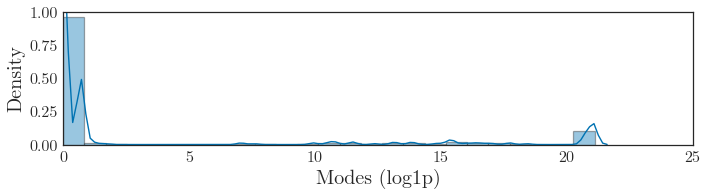

In [502]:
f = plt.figure(figsize = (10,3))
ax = sns.distplot(modes, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=25)
ax.set_ylim(ymin=0, ymax=1)
ax.set_xlabel("Modes (log1p)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"modes.pdf", bbox_inches="tight")

Figure 3. ROC Curve for different imputations - mean, median, mode (line plot).

## 3.2.2 Transformation

--> Apply Imputation

In [ ]:
from sklearn.preprocessing import Imputer

X = X.dropna(axis=1, how = "all")
imp = Imputer(strategy="median")
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, index=X.index, columns=list(X))

--> Shift to positive numbers only

In [ ]:
mins_by_col = X_imp.min(axis=0)#.dropna()
mins_by_col.plot(kind="kde", label="Minimum")

In [ ]:
X_pos = X_imp.subtract(X_imp.min(axis=0))
X_pos.describe()

--> Start transformations

In [ ]:
funding = X_pos["confidence_validation_funding_raised_value_total_number"]

figure = plt.figure()

ax0 = plt.subplot(151)
funding.plot(kind="hist", bins=100)
plt.title("Original - No Transformation") 
print("Skewness (Original): {0:.2f}".format(stats.skew(funding))) 

figure.add_subplot(152, sharey=ax0)
boxcox = pd.Series(stats.boxcox(funding + 1)[0], index=X_pos.index)
boxcox.plot(kind="hist", bins=100)
plt.title("BoxCox Transformation") 
print("Skewness (BoxCox): {0:.2f}".format(stats.skew(boxcox))) 

figure.add_subplot(153, sharey=ax0)
log1p = pd.Series(np.log1p(funding), index=X_pos.index)
log1p.plot(kind="hist", bins=100)
plt.title("Log1P Transformation") 
print("Skewness (Log1P): {0:.2f}".format(stats.skew(log1p)))

figure.add_subplot(154, sharey=ax0)
sqrt = pd.Series(funding**(1/2), index=X_pos.index)
sqrt.plot(kind="hist", bins=100)
plt.title("SQRT Transformation") 
print("Skewness (SQRT): {0:.2f}".format(stats.skew(sqrt)))

from sklearn.preprocessing import binarize

figure.add_subplot(155, sharey=ax0)
binary = pd.Series(np.where(funding == 0, 0, 1), index=X_pos.index)
binary.plot(kind="hist", bins=100)
plt.title("Binary Transformation") 
print("Skewness (Binary): {0:.2f}".format(stats.skew(binary)))

--> Apply transformations

In [ ]:
from sklearn.preprocessing import FunctionTransformer

ft = FunctionTransformer(np.log1p)
X_tf = ft.fit_transform(X_pos)
X_tf = pd.DataFrame(X_tf, index=X_pos.index, columns=list(X_pos))

--> Start scaling

In [ ]:
from sklearn.preprocessing import scale, robust_scale, minmax_scale

funding = X_tf["confidence_validation_funding_raised_value_total_number"]

figure = plt.figure()

ax0 = plt.subplot(151)
funding.plot(kind="hist", bins=100)
plt.title("Original - No Transformation") 
print("Median: {}, IQR: {}".format(funding.median(), stats.iqr(funding)))

figure.add_subplot(152, sharey=ax0)
funding_std = pd.Series(scale(funding), index=X_pos.index)
funding_std.plot(kind="hist", bins=100)
plt.title("Standard Scaling") 
print("Median: {}, IQR: {}".format(funding_std.median(), stats.iqr(funding_std)))


figure.add_subplot(153, sharey=ax0)
funding_robust = pd.Series(robust_scale(funding), index=X_pos.index)
funding_robust.plot(kind="hist", bins=100)
plt.title("Robust Scaling") 
print("Median: {}, IQR: {}".format(funding_robust.median(), stats.iqr(funding_robust)))


figure.add_subplot(154, sharey=ax0)
funding_mm = pd.Series(minmax_scale(funding), index=X_pos.index)
funding_mm.plot(kind="hist", bins=100)
plt.title("Min Max Scaling") 
print("Median: {}, IQR: {}".format(funding_mm.median(), stats.iqr(funding_mm)))

--> Apply scaling

In [ ]:
from sklearn.preprocessing import scale

X_std = scale(X_tf)
X_std = pd.DataFrame(X_std, index=X_tf.index, columns=list(X_tf))

## 3.2.3 Extraction

PCA Model

In [ ]:
#Principal Components Analysis (PCA)
from sklearn.decomposition import PCA

def screeplot(pca, X):
    y = pca.explained_variance_
    x = np.arange(len(y)) + 1
    plt.plot(x, y)
    plt.ylabel("Eigenvalue")
    plt.xlabel("Component Number")
    plt.xlim(1,None)
    return y

pca = PCA().fit(X_std)
eigenvalues = screeplot(pca,X_std)

Grouped

In [ ]:
from collections import defaultdict
from itertools import combinations

features = list(X_std)
f_map = {x: '_'.join(x.split("_")[:3]) for x in features}
f_group = defaultdict(list)
for f,g in f_map.items():
    f_group[g].append(f)
agg_group = {}
for g,l in f_group.items():
    combo = combinations(l, 2)
    for x,y in combo:
        corr = stats.spearmanr(X_std[x][:100], X_std[y][:100])[0]
        if corr < 0: X_std[y] *= -1
    tot = X_std[l].sum(axis=1)
    agg_group[g] = tot
X_grp = pd.DataFrame(agg_group)
grp_corr = X_grp.corr(method="spearman")
mask = np.zeros_like(grp_corr)
mask[np.triu_indices_from(mask)] = True
f_names = [x.split("_")[2] for x in list(X_grp)]
ax = sns.heatmap(grp_corr,square=True, mask=mask, xticklabels=f_names, yticklabels=f_names)
ax.invert_yaxis()

In [ ]:
pca = PCA().fit(X_grp)
eigenvalues = screeplot(pca,X_grp)

# 3.3 Classification

# 3.4 Experimentation

## 3.4.2 Robustness

## 3.4.3 Predictive Power

Table 3.5 Comparison of 2013 slice from 2016 dataset with original 2013 dataset.